In [2]:
# import dependencies
import pandas as pd
import json
import os
import csv
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [3]:
# load data from csv file
data_arr = []

with open('data.csv', newline='') as f:
    reader = csv.reader(f)
    # add each row of the file into an array
    for row in reader:
        data_arr.append(row)

In [5]:
# split the data by patent
scan_reference_arr = []

# start from 2 because of the header and blank line
i = 2

scanamt = [0, 0, 0, 0]
scanamtfinal = [0, 0, 0, 0]

# go through all of the data arrayxs
while (i < len(data_arr)):
    thescan = data_arr[i]
    
    # the number of the patient scan
    scannumber = int(thescan[1]) # this will return a scan number should be i think
    
    
    # if the number of the scan is 1, 5, 9 etc its a new patient based on naming scheme
    if (scannumber % 4 == 1): # we need to start a new entry
        
        # start a new entry in the array for a new patient
        scan_reference_arr.append([])
        
        # count the number of scans in each category
        if (thescan[0] == 'Moderate'):
            scanamt[3] += 1
        if (thescan[0] == 'Mild'):
            scanamt[2] += 1
        if (thescan[0] == 'Verymild'):
            scanamt[1] += 1
        if (thescan[0] == 'Non'):
            scanamt[0] += 1
            
    # limit of the amount of scans we want to use for each category
    # this can be up to around 77 which is the max amount of patients in any category
    # after that it stops taking effect
    limit = 300
    
    # add the scan if the amount of added scans in its category falls below the limit
    if (thescan[0] == 'Moderate' and scanamt[3] < limit):
        scan_reference_arr[len(scan_reference_arr)-1].append(thescan)
        scanamtfinal[3] += 1
    if (thescan[0] == 'Mild' and scanamt[2] < limit):
        scan_reference_arr[len(scan_reference_arr)-1].append(thescan)
        scanamtfinal[2] += 1
    if (thescan[0] == 'Verymild' and scanamt[1] < limit):
        scan_reference_arr[len(scan_reference_arr)-1].append(thescan)
        scanamtfinal[1] += 1
    if (thescan[0] == 'Non' and scanamt[0] < limit):
        scan_reference_arr[len(scan_reference_arr)-1].append(thescan)
        scanamtfinal[0] += 1

    i += 1
    
# know th amount of scans in each category
print(scanamtfinal)

[308, 225, 82, 4]


In [6]:
def load_data():
    
    # reset the test train arrs
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = [], [], [], []

    # shuffle the complete data array
    np.random.shuffle(scan_reference_arr)

    # split it by 80/20 for train/test

    # go through every patient
    i = 0
    while (i < len(scan_reference_arr)):

        # use all the scans from one patient
        for j in scan_reference_arr[i]:

            # get each feature from the data array for the patient's scan
            white_volume = int(j[2])
            black_volume_segmented = int(j[3])
            black_volume_full = int(j[4])
            height = int(j[5]) # don't use this one by itself, it is generally constant because our processing doesn't really affect the height
            width = int(j[6])

            # calculate the total dimensions of the image
            totalarea = height*width

            # get the end features to be put into the model
            white_volume_percentage = white_volume/totalarea
            black_volume_segmented_percentage = black_volume_segmented/totalarea
            black_volume_full_percentage = black_volume_full/totalarea

            # get the Alzheimer's levels fro the data array
            if (j[0] == "Non"):
                Alzheimers_level = 0
            elif (j[0] == "Mild"):
                Alzheimers_level = 1
            elif (j[0] == "Verymild"):
                Alzheimers_level = 1
            # exclude moderate Alzheimer's because of lack of data


            # if the scan is in the first 80% then put into train dataset
            if (i < len(scan_reference_arr)*0.9):
                # exclude moderate Alzheimer's because of lack of data
                if (scan_reference_arr[i][0] == "Moderate"):
                    pass #exclude
                else:
                    # add the features to the x array and the Alzheimer's severity into the y array
                    X_train.append([white_volume_percentage,black_volume_segmented_percentage, black_volume_full_percentage])
                    y_train.append(Alzheimers_level)
            else:
                # if the scan is in the end 20% then put into train dataset
                if (scan_reference_arr[i][0] == "Moderate"):
                    pass #exclude
                else:
                    # add the features to the x array and the Alzheimer's severity into the y array
                    X_test.append([white_volume_percentage,black_volume_segmented_percentage, black_volume_full_percentage])
                    y_test.append(Alzheimers_level)

        i += 1
        

In [7]:
# if you need to run resplitting into sets seperately
# load_data()

In [8]:
# trains a random forest model on the data one time
load_data()

def trainrfclassifier():
    global X_train, X_test, y_train, y_test
    
    # create the model
    rf = RandomForestClassifier()
    
    # train it on the train data
    rf.fit(X_train, y_train)
    
    # test the model on the test data
    y_pred1 = rf.predict(X_test)

    # get the performance statistics
    accuracy = accuracy_score(y_test, y_pred1)
    f_score = f1_score(y_test, y_pred1, average="weighted")
    
    # print out some metrics
    print("Accuracy:", accuracy, "\t\tF-score:", f_score)
    
    return [accuracy, f_score, rf]
    


# train the model number_runs times, get the average statistics
accuracy_sum = 0
f_score_sum = 0
accuracy_max = 0
f_score_max = 0
number_runs = 100

# train for number_runs times
# resplit test/train every 5 runs
for i in range(number_runs):
    model_results = trainrfclassifier()
    
    accuracy_sum += model_results[0]
    f_score_sum += model_results[1]

    if (model_results[0] > accuracy_max):
        accuracy_max = model_results[0]
    if (model_results[1] > f_score_max):
        f_score_max = model_results[1]
        
    if (i % 5 == 0):
        load_data()

    
print("Average accuracy: ",accuracy_sum/number_runs)
print("Average f score",f_score_sum/number_runs)

print("Max accuracy: ",accuracy_max)
print("Max f score",f_score_max)

Accuracy: 0.7049180327868853 		F-score: 0.6984381922906513
Accuracy: 0.6833333333333333 		F-score: 0.6965316234334014
Accuracy: 0.7 		F-score: 0.7123384253819036
Accuracy: 0.6333333333333333 		F-score: 0.648
Accuracy: 0.7 		F-score: 0.7125
Accuracy: 0.6666666666666666 		F-score: 0.6805555555555555
Accuracy: 0.7049180327868853 		F-score: 0.7082567834934991
Accuracy: 0.6885245901639344 		F-score: 0.692896174863388
Accuracy: 0.6885245901639344 		F-score: 0.692896174863388
Accuracy: 0.6885245901639344 		F-score: 0.6941032542206997
Accuracy: 0.6721311475409836 		F-score: 0.6774536938471365
Accuracy: 0.6031746031746031 		F-score: 0.6009727976941092
Accuracy: 0.5555555555555556 		F-score: 0.5544354838709679
Accuracy: 0.5873015873015873 		F-score: 0.5862615207373272
Accuracy: 0.5555555555555556 		F-score: 0.5515151515151516
Accuracy: 0.5555555555555556 		F-score: 0.5476673427991886
Accuracy: 0.6984126984126984 		F-score: 0.6960742080928174
Accuracy: 0.6666666666666666 		F-score: 0.658008658008

In [ ]:
load_data()

0.8412698412698413


<AxesSubplot:>

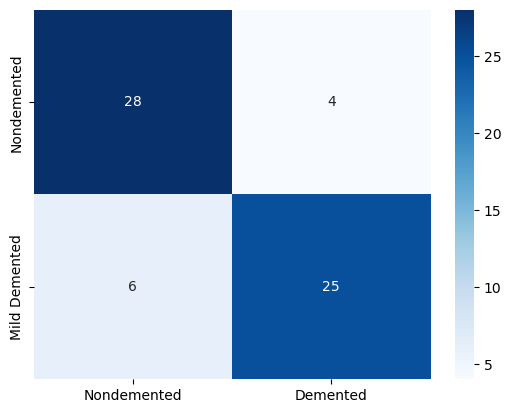

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

# plot a confusion matrix

load_data()
# create the model
rf = RandomForestClassifier()

# train it on the train data
rf.fit(X_train, y_train)

# test the model on the test data
y_pred1 = rf.predict(X_test)

# get the performance statistics
accuracy = accuracy_score(y_test, y_pred1)
f_score = f1_score(y_test, y_pred1, average="weighted")


print(accuracy)

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred1), index = ["Nondemented","Mild Demented"], columns = ["Nondemented","Demented"])

sn.heatmap(df_cm, annot=True, fmt='', cmap='Blues')

Accuracy: 0.8571428571428571 		F-score: 0.8567091901268475


[Text(0.4640151515151515, 0.9705882352941176, '[9.082692629115828, 37.013016045462145, 68.0024444258733] <= 30.0\ngini = 0.497\nsamples = 355\nvalue = [298, 258]'),
 Text(0.17803030303030304, 0.9117647058823529, '[11.231658395368072, 33.50159222497932, 60.073779983457406] <= 11.645\ngini = 0.358\nsamples = 158\nvalue = [54, 177]'),
 Text(0.09090909090909091, 0.8529411764705882, '[11.231658395368072, 33.50159222497932, 60.073779983457406] <= 8.822\ngini = 0.399\nsamples = 25\nvalue = [29, 11]'),
 Text(0.07575757575757576, 0.7941176470588235, 'gini = 0.0\nsamples = 4\nvalue = [0, 5]'),
 Text(0.10606060606060606, 0.7941176470588235, '[9.082692629115828, 37.013016045462145, 68.0024444258733] <= 29.469\ngini = 0.284\nsamples = 21\nvalue = [29, 6]'),
 Text(0.09090909090909091, 0.7352941176470589, '[9.082692629115828, 37.013016045462145, 68.0024444258733] <= 29.208\ngini = 0.346\nsamples = 17\nvalue = [21, 6]'),
 Text(0.06060606060606061, 0.6764705882352942, '[11.231658395368072, 33.501592224

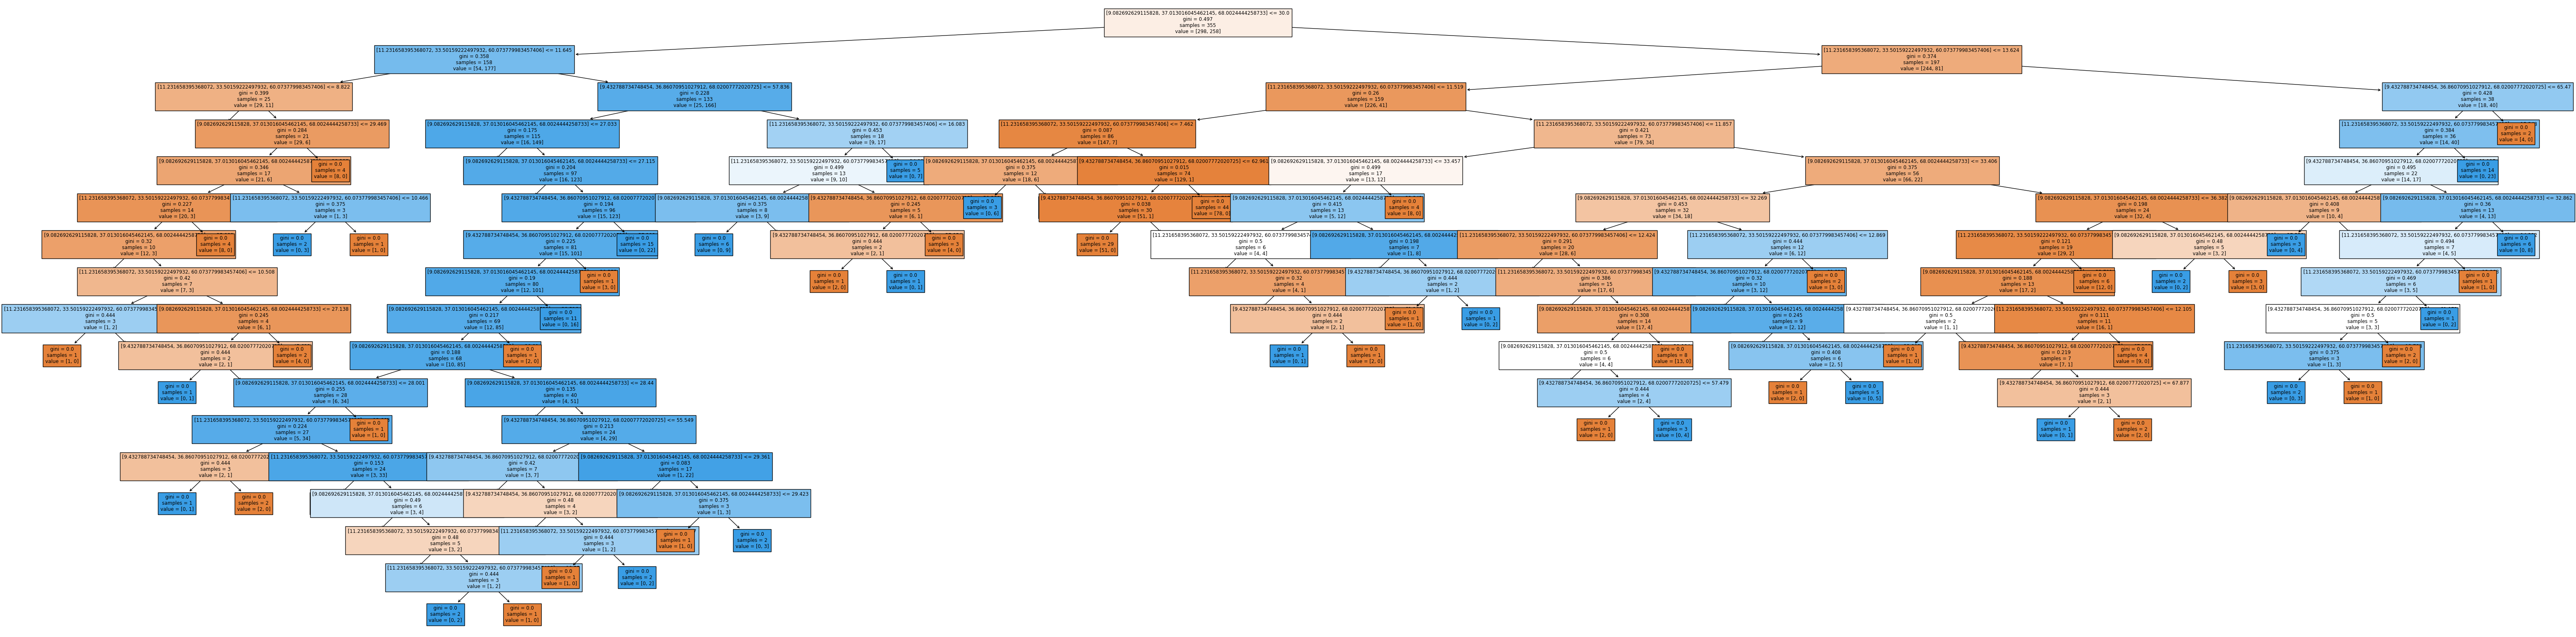

In [10]:
# plot a random forest visualization
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

# get a model
rf = trainrfclassifier()[2]

# set tree specifications and plot it
plt.figure(figsize=(80,20))
tree.plot_tree(rf.estimators_[0], feature_names=X_test, filled=True, fontsize=8.5) #, class_names=["Non Demented","Demented"], max_depth=7)
